# 2.2. MadaLine

## 2.2.B. Define and Plot Data

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

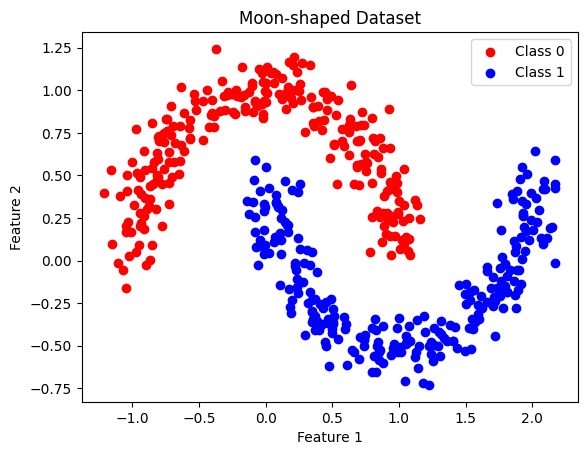

In [ ]:
X_moons, Y_moons = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train_moons, X_test_moons, Y_train_moons, Y_test_moons = train_test_split(X_moons, Y_moons, test_size=0.5, random_state=3)

plt.scatter(X_moons[Y_moons == 0][:, 0], X_moons[Y_moons == 0][:, 1], color='red', label='Class 0')
plt.scatter(X_moons[Y_moons == 1][:, 0], X_moons[Y_moons == 1][:, 1], color='blue', label='Class 1')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title("Moon-shaped Dataset")
plt.show()

In [ ]:
Y_moons[np.isclose(Y_moons, 0)] = -1

## 2.2.C. MRI Implementation

In [ ]:
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def find_decision_boundary(start_x, end_x, weights, biases):
    inputs = np.linspace(start_x, end_x)
    output = -(weights[0] * inputs + biases)
    output = output / weights[1]
    return inputs, output

def initialize_weights(sm, num_neurons_layer1, num_neurons_layer2):
    np.random.seed(10)
    weights = np.random.rand(num_neurons_layer1, num_neurons_layer2) * sm
    biases = np.zeros((num_neurons_layer1, 1))
    weights_layer2 = np.array([[1]*num_neurons_layer1])
    biases_layer2 = num_neurons_layer1 - 1
    return weights, biases, weights_layer2, biases_layer2

def apply_activation_function(net):
    h = np.where(net >= 0, 1, -1)
    return h

def forward_propagation(weights, inputs, biases, should_reshape):
    if should_reshape:
        inputs = inputs.reshape((2, 1))
    net_input = np.dot(weights, inputs) + biases
    outputs = apply_activation_function(net_input)
    return net_input, outputs

def update_weights(weights, biases, inputs, target, net_input, output, learning_rate, num_neurons_layer1):
    inputs = inputs.reshape((1, 2))
    net_input = net_input.reshape((num_neurons_layer1, 1))
    if target == output:
        return weights, biases
    elif target == 1 and target != output:    #output=-1 but target=1
        argmax_neuron = np.argmax(net_input)
        diff_bias = learning_rate * (1 - net_input[argmax_neuron])
        diff_weight = learning_rate * np.dot((1 - net_input[argmax_neuron]), inputs)
        biases[argmax_neuron] = biases[argmax_neuron] + diff_bias
        weights[argmax_neuron] = weights[argmax_neuron] + diff_weight
    elif target == -1 and target != output:   # output=1 but target=-1
        positive_indices = np.argwhere(net_input > 0)
        diff_bias = learning_rate * (-1 - net_input)
        diff_weight = learning_rate * np.dot((-1 - net_input), inputs)
        new_biases = biases + diff_bias
        new_weights = weights + diff_weight
        for i in positive_indices[:, 0]:
            weights[i] = new_weights[i]
            biases[i] = new_biases[i]
    return weights, biases

def calculate_error(target, output):
    error = 0.5 * np.power((target - output), 2)
    return error

def predict(inputs, target, weights, biases, num_neurons_layer1):
    predicted_output = []
    biases_layer2 = np.zeros((num_neurons_layer1, 1))
    weights_layer2 = np.array([[1]*num_neurons_layer1])
    biases_layer2 = num_neurons_layer1 - 1
    for i in range(inputs.shape[0]):
        net_input, outputs = forward_propagation(weights, inputs[i], biases, should_reshape=True)
        net_input2, output = forward_propagation(weights_layer2, outputs, biases_layer2, should_reshape=False)
        predicted_output.append(output[0])
    return predicted_output


def MRI(df0, df1, inputs, target, num_neurons_layer1=3, num_neurons_layer2=2, learning_rate=0.0001, max_iter=200, samples=None, plot=True):
    if samples is None:
        samples = inputs.shape[0]
    print('sample:', samples)
    sm = 0.001
    error_list = []
    errors = []
    mean_error = 10**3
    weights, biases, weights_layer2, biases_layer2 = initialize_weights(sm, num_neurons_layer1, num_neurons_layer2)  # Step 0
    for i in range(max_iter):
        net_input, outputs = forward_propagation(weights, inputs[i % samples], biases, should_reshape=True)  # Step 4 and 5
        net_input2, output = forward_propagation(weights_layer2, outputs, biases_layer2, should_reshape=False)  # Step 6
        error = calculate_error(target[i % samples], output)
        errors.append(error)
        if i % samples == 0 and i != 0:
            mean_error = np.mean(errors)
            error_list.append(mean_error)
            errors = []
            print('Epoch %d / %d' % (len(error_list), int(max_iter / samples)))
            print('loss:', mean_error)
            for j in range(len(weights)):
                print('W%d:'%(j+1),weights[j])
                print('b%d:'%(j+1),biases[j])
        if mean_error == 0 or (i > 50 and len(error_list) >= 2 and error_list[-1] - error_list[-2] == 0):
            print('An early stop occurred!')
            if plot:
                plt.plot(error_list)
                plt.xlabel('Epochs')
                plt.ylabel('Mean Squared Error')
                plt.title('Error Plot')
                plt.grid(True)
                plt.savefig('error_plot.pdf')
                plt.show()
                df0 = df0
                df1 = df1
                plt.scatter(df0['x'], df0['y'], c ="red", linewidths = 0.1)
                plt.scatter(df1['x'], df1['y'], c ="blue", linewidths = .1)

                for i in range(num_neurons_layer1):
                    px1, px2 = find_decision_boundary(-2, 2, weights[i], biases[i])
                    plt.plot(px1, px2)

                plt.xlabel("x")
                plt.ylabel("y")
                plt.legend(["Class 1" , "Class 2"])
                plt.xlim([-2, 2])
                plt.ylim([-2, 2])
                plt.savefig('error_plot1.pdf')
                plt.show()
                # Generate predictions
                predicted_output = predict(inputs, target, weights, biases, num_neurons_layer1)
                # Create confusion matrix
                cm = confusion_matrix(target, predicted_output)
                # Plot heatmap of confusion matrix
                plt.figure(figsize=(6, 4))
                sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
                plt.xlabel("Predicted labels")
                plt.ylabel("True labels")
                plt.title("Confusion Matrix")
                plt.tight_layout()
                # Save plot as PDF
                plt.savefig("confusion_matrix.pdf")
                plt.show()
                predicted_output = predict(inputs, target,weights,biases,num_neurons_layer1)
                print(classification_report(target, predicted_output))
            return weights, biases, error_list
        weights, b = update_weights(weights, biases, inputs[i % samples], target[i % samples], net_input, output, learning_rate, num_neurons_layer1)  # Step 7

    if plot:
        df0 = df0
        df1 = df1
        plt.scatter(df0[:,0], df0[:,1], c ="red", linewidths = 0.1)
        plt.scatter(df1[:,0], df1[:,1], c ="blue", linewidths = .1)

        for i in range(num_neurons_layer1):
            px1, px2 = find_decision_boundary(-2, 2, weights[i], biases[i])
            plt.plot(px1, px2)

        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend(["Class 1" , "Class 2"])
        plt.xlim([-2, 2])
        plt.ylim([-2, 2])
        plt.savefig('error_plot1.pdf')
        plt.show()
        # Generate predictions
        predicted_output = predict(inputs, target, weights, biases, num_neurons_layer1)
        # Create confusion matrix
        cm = confusion_matrix(target, predicted_output)
        # Plot heatmap of confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
        plt.xlabel("Predicted labels")
        plt.ylabel("True labels")
        plt.title("Confusion Matrix")
        plt.tight_layout()
        # Save plot as PDF
        plt.savefig("confusion_matrix.pdf")
        plt.show()
        predicted_output = predict(inputs, target,weights,biases,num_neurons_layer1)
        print(classification_report(target, predicted_output))

    return weights, biases, error_list

### Madaline Results (3 neurons)

sample: 500


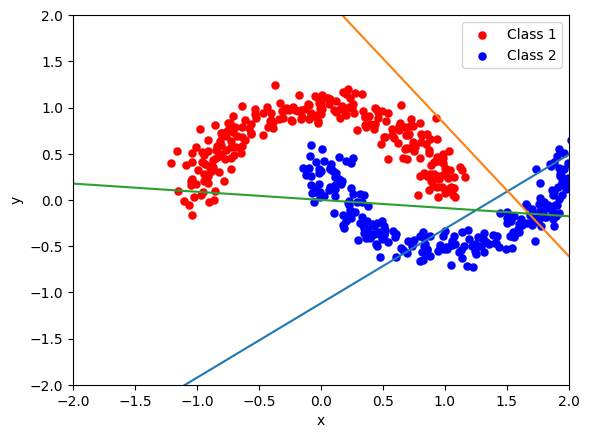

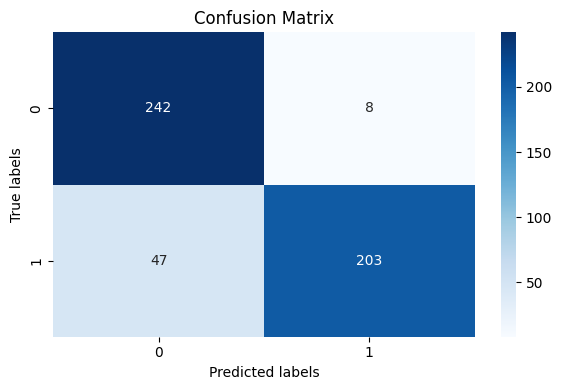

              precision    recall  f1-score   support

          -1       0.84      0.97      0.90       250
           1       0.96      0.81      0.88       250

    accuracy                           0.89       500
   macro avg       0.90      0.89      0.89       500
weighted avg       0.90      0.89      0.89       500



In [ ]:
weights, biases, error_list = MRI(X_moons[Y_moons == -1], X_moons[Y_moons == 1], X_moons,Y_moons,num_neurons_layer1 = 3 ,num_neurons_layer2 = 2,max_iter = 150,learning_rate = 0.0001,samples = X_moons.shape[0])

### Madaline Results (5 neurons)

sample: 500


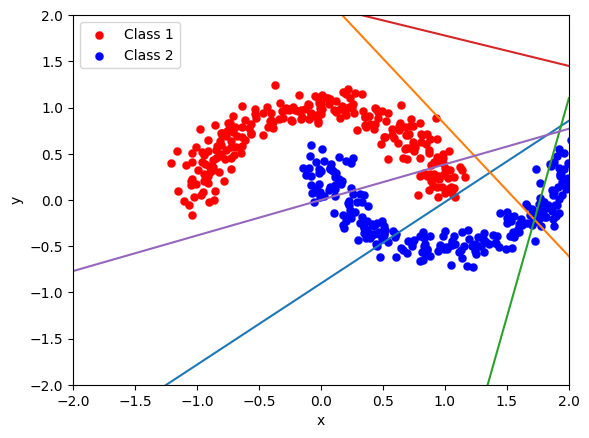

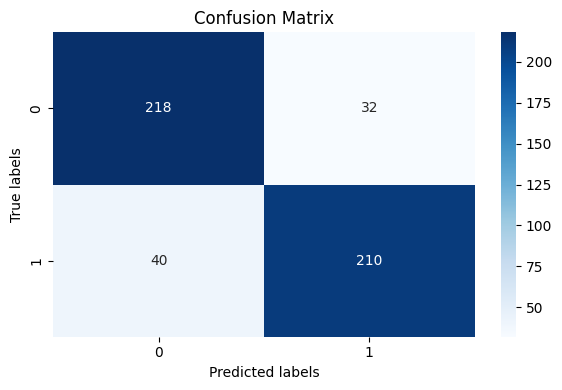

              precision    recall  f1-score   support

          -1       0.84      0.87      0.86       250
           1       0.87      0.84      0.85       250

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [ ]:
weights, biases, error_list = MRI(X_moons[Y_moons == -1], X_moons[Y_moons == 1], X_moons,Y_moons,num_neurons_layer1 = 5 ,num_neurons_layer2 = 2,max_iter = 200,learning_rate = 0.0001,samples = X_moons.shape[0])

### Madaline Results (8 neurons)

sample: 500


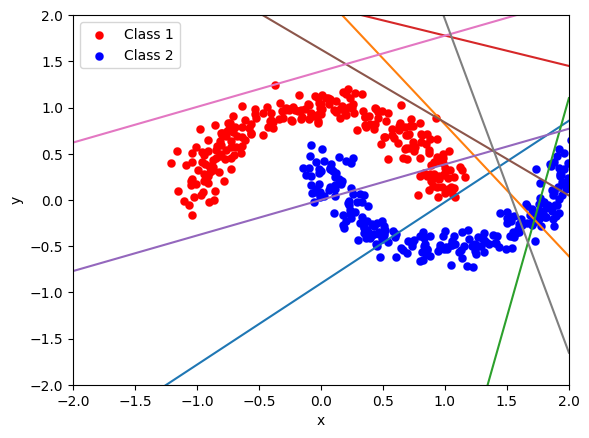

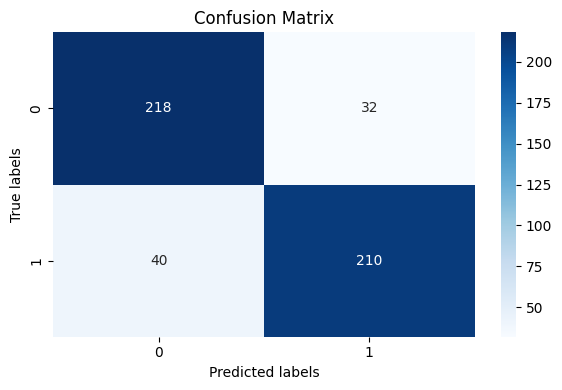

              precision    recall  f1-score   support

          -1       0.84      0.87      0.86       250
           1       0.87      0.84      0.85       250

    accuracy                           0.86       500
   macro avg       0.86      0.86      0.86       500
weighted avg       0.86      0.86      0.86       500



In [ ]:
weights, biases, error_list = MRI(X_moons[Y_moons == -1], X_moons[Y_moons == 1], X_moons,Y_moons,num_neurons_layer1 = 8 ,num_neurons_layer2 = 2,max_iter = 200,learning_rate = 0.0001,samples = X_moons.shape[0])
